In [1]:
import numpy as np

SQUEEZENET_MEAN = np.array([0.0, 0.0, 0.0], dtype=np.float32)
SQUEEZENET_STD = np.array([0.01, 0.01, 0.01], dtype=np.float32)
def preprocess_image(img):
    """Preprocess an image for squeezenet.
    
    Subtracts the pixel mean and divides by the standard deviation.
    """
    
    return (img.astype(np.float32)/255.0 - SQUEEZENET_MEAN) / SQUEEZENET_STD


def deprocess_image(img, rescale=False):
    """Undo preprocessing on an image and convert back to uint8."""               
    img = (img * SQUEEZENET_STD + SQUEEZENET_MEAN)
    if rescale:
        vmin, vmax = img.min(), img.max()
        img = (img - vmin) / (vmax - vmin)
    return np.clip(255 * img, 0.0, 255.0).astype(np.uint8)

In [2]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    return X

In [3]:
def create_class_visualization(target_y, images, scores, sess, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    X = 255 * np.random.rand(299, 299, 3)
    X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    loss = None # scalar loss
    grad = None # gradient of loss with respect to model.image, same size as model.image
    
    #calculate the scores
    #loss = tf.Variable((model.classifier[0,target_y]), name='loss')
    #init = tf.global_variables_initializer()
    #sess.run(init)
    input_norm  = tf.norm(
        images,
        ord='euclidean',
        axis=None,
        keep_dims=False,
        name=None
    )        
    
    #loss = scores - l2_reg*input_norm
    loss = tf.subtract(scores, l2_reg * (input_norm**2))
    #loss = scores
    grads = tf.gradients(loss, images)    
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)
        
        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ######################################################################## 
        dX, _, _ = sess.run([grads, loss, input_norm], '')         
        X += learning_rate * dX[0][0][0]        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)
            
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess_image(X[0]))
            class_name = "Background"
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()                 
    return X

In [4]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import matplotlib.pyplot as plt
import tensorflow as tf


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
INFO:tensorflow:Summary name eval/Recall@5 is illegal; using eval/Recall_5 instead.
INFO:tensorflow:Evaluating /media/sunsys-stash/datasets/python-dataset-ilids/train/model.ckpt-200000
INFO:tensorflow:Starting evaluation at 2017-06-08-08:08:23
INFO:tensorflow:Restoring parameters from /media/sunsys-stash/datasets/python-dataset-ilids/train/model.ckpt-200000
INFO:tensorflow:Evaluation [1/15]
INFO:tensorflow:Evaluation [2/15]
INFO:tensorflow:Evaluation [3/15]
INFO:tensorflow:Evaluation [4/15]
INFO:tensorflow:Evaluation [5/15]
INFO:tensorflow:Evaluation [6/15]
INFO:tensorflow:Evaluation [7/15]
INFO:tensorflow:Evaluation [8/15]
INFO:tensorflow:Evaluation [9/15]
INFO:tensorflow:Evaluation [10/15]
INFO:tensorflow:Evaluation [11/15]
INFO:tensorflow:Evaluation [12/15]
INFO:tensorflow:Evaluation [13/15]
INFO:tensorflow:Ev

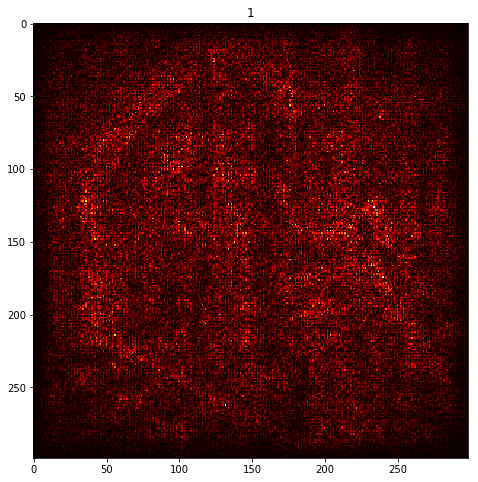

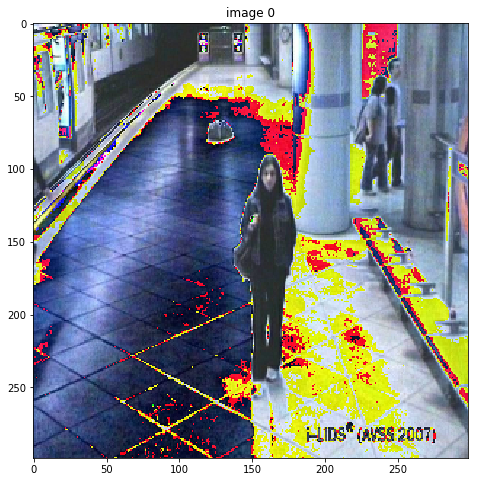

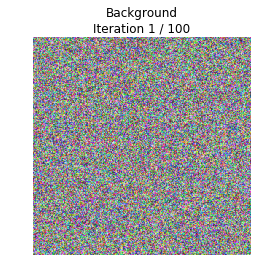

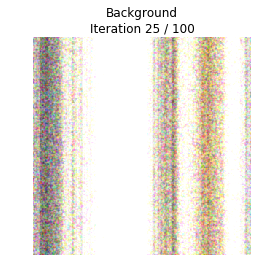

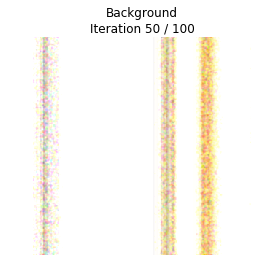

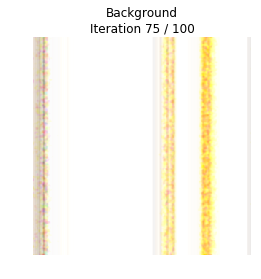

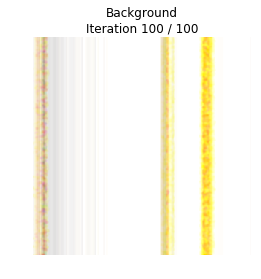

SystemExit: 

/home/sunsys/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2855: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Generic evaluation script that evaluates a model using a given dataset."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import tensorflow as tf

from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

import numpy as np

slim = tf.contrib.slim

tf.app.flags.DEFINE_integer(
    'batch_size', 100, 'The number of samples in each batch.')

tf.app.flags.DEFINE_integer(
    'max_num_batches', None,
    'Max number of batches to evaluate by default use all.')

tf.app.flags.DEFINE_string(
    'master', '', 'The address of the TensorFlow master to use.')

tf.app.flags.DEFINE_string(
    'checkpoint_path', '/media/sunsys-stash/datasets/python-dataset-ilids/train',
    'The directory where the model was written to or an absolute path to a '
    'checkpoint file.')

tf.app.flags.DEFINE_string(
    'eval_dir', '/tmp/tfmodel/', 'Directory where the results are saved to.')

tf.app.flags.DEFINE_integer(
    'num_preprocessing_threads', 4,
    'The number of threads used to create the batches.')

tf.app.flags.DEFINE_string(
    'dataset_name', 'baggage', 'The name of the dataset to load.')

tf.app.flags.DEFINE_string(
    'dataset_split_name', 'validation', 'The name of the train/test split.')

tf.app.flags.DEFINE_string(
    'dataset_dir', '/media/sunsys-stash/datasets/python-dataset-ilids', 'The directory where the dataset files are stored.')

tf.app.flags.DEFINE_integer(
    'labels_offset', 0,
    'An offset for the labels in the dataset. This flag is primarily used to '
    'evaluate the VGG and ResNet architectures which do not use a background '
    'class for the ImageNet dataset.')

tf.app.flags.DEFINE_string(
    'model_name', 'inception_v3', 'The name of the architecture to evaluate.')

tf.app.flags.DEFINE_string(
    'preprocessing_name', None, 'The name of the preprocessing to use. If left '
    'as `None`, then the model_name flag is used.')

tf.app.flags.DEFINE_float(
    'moving_average_decay', None,
    'The decay to use for the moving average.'
    'If left as None, then moving averages are not used.')

tf.app.flags.DEFINE_integer(
    'eval_image_size', None, 'Eval image size')

FLAGS = tf.app.flags.FLAGS

def write_jpeg(data, filepath):
    g = tf.Graph()
    with g.as_default():
        data_t = tf.placeholder(tf.uint8)
        op = tf.image.encode_jpeg(data_t, format='', quality=100)
        init = tf.initialize_all_variables()

    with tf.Session(graph=g) as sess:
        sess.run(init)
        data_np = sess.run(op, feed_dict={ data_t: data })

    with open(filepath, 'w') as fd:
        fd.write(data_np)

def show_saliency_maps(images, labels, mask, saliency):
    mask = np.asarray(mask, dtype=np.int32)
    Xm = images[mask]
    ym = labels[mask]

    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
        plt.show()

def main(_):
  if not FLAGS.dataset_dir:
    raise ValueError('You must supply the dataset directory with --dataset_dir')

  tf.logging.set_verbosity(tf.logging.INFO)
  with tf.Graph().as_default():
    tf_global_step = slim.get_or_create_global_step()

    ######################
    # Select the dataset #
    ######################
    dataset = dataset_factory.get_dataset(
        FLAGS.dataset_name, FLAGS.dataset_split_name, FLAGS.dataset_dir)

    ####################
    # Select the model #
    ####################
    network_fn = nets_factory.get_network_fn(
        FLAGS.model_name,
        num_classes=(dataset.num_classes - FLAGS.labels_offset),
        is_training=False)

    ##############################################################
    # Create a dataset provider that loads data from the dataset #
    ##############################################################
    provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset,
        shuffle=False,
        common_queue_capacity=2 * FLAGS.batch_size,
        common_queue_min=FLAGS.batch_size)
    [image, label] = provider.get(['image', 'label'])
    label -= FLAGS.labels_offset

    #####################################
    # Select the preprocessing function #
    #####################################
    preprocessing_name = FLAGS.preprocessing_name or FLAGS.model_name
    image_preprocessing_fn = preprocessing_factory.get_preprocessing(
        preprocessing_name,
        is_training=False)

    eval_image_size = FLAGS.eval_image_size or network_fn.default_image_size

    image = image_preprocessing_fn(image, eval_image_size, eval_image_size)

    images, labels = tf.train.batch(
        [image, label],
        batch_size=FLAGS.batch_size,
        num_threads=FLAGS.num_preprocessing_threads,
        capacity=5 * FLAGS.batch_size)

    ####################
    # Define the model #
    ####################
    logits, _ = network_fn(images)

    if FLAGS.moving_average_decay:
      variable_averages = tf.train.ExponentialMovingAverage(
          FLAGS.moving_average_decay, tf_global_step)
      variables_to_restore = variable_averages.variables_to_restore(
          slim.get_model_variables())
      variables_to_restore[tf_global_step.op.name] = tf_global_step
    else:
      variables_to_restore = slim.get_variables_to_restore()

    predictions = tf.argmax(logits, 1)
    labels = tf.squeeze(labels)

    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'Recall@5': slim.metrics.streaming_recall_at_k(
            logits, labels, 5),
    })

    # Print the summaries to screen.
    for name, value in names_to_values.items():
      summary_name = 'eval/%s' % name
      op = tf.summary.scalar(summary_name, value, collections=[])
      op = tf.Print(op, [value], summary_name)
      tf.add_to_collection(tf.GraphKeys.SUMMARIES, op)

    # TODO(sguada) use num_epochs=1
    if FLAGS.max_num_batches:
      num_batches = FLAGS.max_num_batches
    else:
      # This ensures that we make a single pass over all of the data.
      num_batches = math.ceil(dataset.num_samples / float(FLAGS.batch_size))

    if tf.gfile.IsDirectory(FLAGS.checkpoint_path):
      checkpoint_path = tf.train.latest_checkpoint(FLAGS.checkpoint_path)
    else:
      checkpoint_path = FLAGS.checkpoint_path

    tf.logging.info('Evaluating %s' % checkpoint_path)

    slim.evaluation.evaluate_once(
        master=FLAGS.master,
        checkpoint_path=checkpoint_path,
        logdir=FLAGS.eval_dir,
        num_evals=num_batches,
        eval_op=list(names_to_updates.values()),
        variables_to_restore=variables_to_restore)
    
    
    ##Start Saliency Map Generation
    
    sess = tf.Session()
    init = tf.initialize_all_variables()
    sess.run(init)
    classifier = tf.reshape(images,[-1, dataset.num_classes - FLAGS.labels_offset])
    correct_scores = tf.gather_nd(classifier,
                                  tf.stack((tf.cast(tf.range(FLAGS.batch_size), tf.int64), labels), axis=1))
    
    scores = tf.nn.sparse_softmax_cross_entropy_with_logits(
        _sentinel=None,
        labels=labels,
        logits=logits,
        name=None
    )

    dcross_entropy_loss = tf.gradients(
        scores,
        images,
        grad_ys=None,
        name='gradients',
        colocate_gradients_with_ops=False,
        gate_gradients=False,
        aggregation_method=None
    )
    #print(dcross_entropy_loss[0])
    #saliency = np.abs(np.amax(dcross_entropy_loss[0],3))
    
    saliency = tf.abs(tf.reduce_max(dcross_entropy_loss[0], axis=3))                
    
    with sess.as_default():
        tf.train.start_queue_runners()
        npArray0 = saliency[15].eval()
        npArrayImg0 = images[15].eval()
        #npArray1 = saliency[1].eval()
        #npArray2 = saliency[23].eval()
        #npArrayImg2 = images[23].eval()
        #npArray3 = saliency[3].eval()
        #npArray4 = saliency[4].eval()
        labels1 = labels.eval()
        
        #writefile = tf.write_file(filename, strImage)
        
    #print(labels1)
    #print(npArrayImg0)    
    
    plt.title(labels1[15])
    plt.imshow(npArray0, cmap=plt.cm.hot)
    plt.show()
    plt.title("image 0")
    plt.imshow(npArrayImg0)
    plt.show()
    
    #plt.title(labels1[1])
    #plt.imshow(npArray1, cmap=plt.cm.hot)
    #plt.show()
    
    #plt.title(labels1[23])
    #plt.imshow(npArray2, cmap=plt.cm.hot)
    #plt.show()
    #plt.title("image 2")
    #plt.imshow(npArrayImg2)
    #plt.show()
    
    #plt.title(labels1[3])
    #plt.imshow(npArray3, cmap=plt.cm.hot)
    #plt.show()
    
    #plt.title(labels1[4])
    #plt.imshow(npArray4, cmap=plt.cm.hot)
    #plt.show()
    252532/11
    #print("file written")
    
    #print(writefile)
    
    #class visualization
    target_y = 0 # Abandoned
    out = create_class_visualization(target_y, images, scores, sess)
    
if __name__ == '__main__':
  tf.app.run()